In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import yfinance as yf

A common SDE in finance is the GBM, which can be used to model stock prices. The SDE is as follows:
$$
dX_t = \mu_t X_t dt + \sigma X_t dW_t
$$
where $W_t \sim \mathcal{N}(0, t)$ is a standard Weiner-process. One can substitute $X_t$ for a price process of a stock $S_t$ and model with the above.

In [7]:
ticker = "NVO"
data = yf.download(ticker, start="2024-01-28", end="2025-01-28")

print(data.head())

[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open    Volume
Ticker             NVO         NVO         NVO         NVO       NVO
Date                                                                
2024-01-29  107.835434  107.835434  106.529777  106.955105   3915900
2024-01-30  107.835434  108.142071  107.281521  108.003593   5105000
2024-01-31  113.493294  114.858304  110.931439  110.931439  12716100
2024-02-01  114.531883  114.601122  112.108499  112.761332   6837200
2024-02-02  112.464584  113.354807  112.009583  112.523938   5136000


We not want to calculate the log-returns since we need this to estimate the $\mu_t$ and $\sigma_t$. Also here we touch upon the time variability of the drift and diffusion parameters. I think it could be smart to model this with some sort of time series models, perhaps the drift could be choosen from a markov-switching model, and so could the diffusion, since they are both time varying and regime sensitive. 

In [8]:
data["log_return"] = np.log(data["Close"] / data["Close"].shift(1))

data.dropna()


mu = data["log_return"].mean()*252 
sigma = data["log_return"].std()*np.sqrt(252)

print(f"Estimated drift: {mu}")
print(f"Estimated volatility: {sigma}")


Estimated drift: -0.21136951214890964
Estimated volatility: 0.3829195136408773


C:\Users\oskar\AppData\Local\Temp\ipykernel_2476\3226002210.py:1: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  S0 = float(data['Close'].iloc[-1])


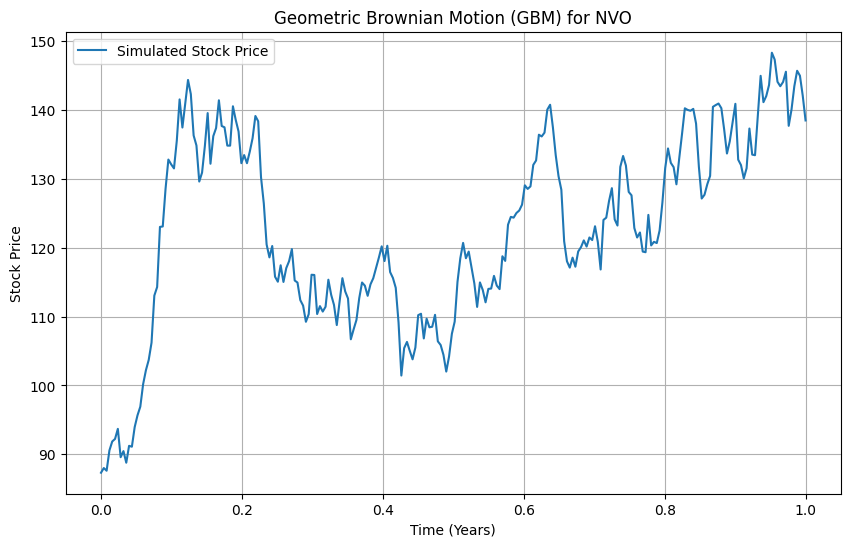

In [9]:
S0 = float(data['Close'].iloc[-1])
T = 1  
N = 252  
dt = T / N  


dW = np.random.normal(0, np.sqrt(dt), N)
W = np.cumsum(dW)

t = np.linspace(0, T, N)
S = S0 * np.exp((mu - 0.5 * sigma**2) * t + sigma * W)

plt.figure(figsize=(10, 6))
plt.plot(t, S, label='Simulated Stock Price')
plt.title(f'Geometric Brownian Motion (GBM) for {ticker}')
plt.xlabel('Time (Years)')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.show()


So here we have simulated one sample path of the SDE. We can use this to price european call options. 

In [13]:
def black_scholes(S, K, T, r, sigma, option_type='call'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return price

In [15]:
K = 88  # Strike price
T = 3 / 365  # Time to maturity in years
r = 0.02  # Risk-free rate
  # Volatility

call_price = black_scholes(S, K, T, r, sigma, option_type='call')
put_price = black_scholes(S, K, T, r, sigma, option_type='put')

print(f"Call option price: {call_price}")
print(f"Put option price: {put_price}")

Call option price: [ 0.91463299  1.23113331  1.04195636  2.93933079  4.03954524  4.37632911
  5.7579827   2.19068122  2.85404663  1.66311221  3.48828283  3.37745091
  6.00831819  7.68286017  8.93440325 12.18622273 14.22299004 15.72142691
 18.21798189 25.06005893 26.30385096 35.02936118 35.09023288 40.57795643
 44.80339039 44.10511394 43.51783951 47.53627146 53.53347025 49.4536731
 52.9126161  56.35717912 54.30334778 48.29835622 46.84535642 41.60934582
 42.90774447 46.76057589 51.54753701 44.19503407 48.2032823  49.38035889
 53.4059481  49.67419057 49.4813433  46.82735818 46.82294711 52.53615349
 50.55173076 48.87646416 44.27524595 45.45290544 44.27431011 45.95101773
 47.9021862  51.12649353 50.36243145 42.26422302 38.42419251 32.47319866
 30.60281563 32.2508282  27.79857308 27.06992806 29.45554537 27.03490964
 29.04875988 30.04817759 31.80636499 27.25209843 26.94769249 24.39713976
 23.60286776 21.25364346 22.36465965 28.0821486  28.04956977 22.37979579
 23.52557626 22.73621351 23.44021